# Low-Dimensional Score-Based Generative Modeling with Linear SDEs


This notebook demonstrates how to set up **score-based generative modeling** (Song et al., 2021) for **low-dimensional** liner stochastic differential equations (SDEs) with:
- a **central attractor** at the origin (drift pointing toward zero, not necessarily a gradient field / non-reversible), and
- **isotropic, homogeneous diffusion** (scalar noise level \(\sigma\), i.e. \(g(t) = \sigma\)).

We cover both **2D (K=2)** and **3D (K=3)** cases, support **analytically-defined initial distributions** \(p_0\) on simple manifolds (e.g., quarter circle in 2D) or in a ball (uniform in volume), and show how to:

1. Simulate the **forward SDE** from \(p_0\) to time \(T\).

2. Train a time-dependent **score network** \(s_\theta(x,t) \approx \nabla_x \log p_t(x)\) using **denoising score matching** (we use the conditional Gaussian for our linear SDE to compute exact targets).

3. **Sample** by integrating the **reverse-time SDE** with Euler–Maruyama **or** the **probability flow ODE** with Euler (deterministic sampling).

4. **Visualize** trajectories and distributions over time, including the terminal distribution \(p_T\).


**TODO**

- Compute analytically the quasipotential in the linear case
- Use DPA to estimate p_t(x) for each t (*), this may be the target of the score network:
  learning a p_t which is differentiable and obtained from DPA
- Show the quasipotential p_T(x) ---> U(x,T) for large enough T
- Extend to generic non-linear case
- Compare with known quasipotential in non-linear SDEs
- Estimate the computational complexity of these estimates vs known alternative methods
- Extend to the temporal dependent case
- Check scaling with dimensionality K
  



> **Note**: This notebook is designed to be **self-contained** and educational. It does not depend on the original `yang-song/score_sde` repo internals, but the structure mirrors the ideas there. You can use this as a template to later add a **custom SDE class** to `sde_lib.py` and a **dataset/sampler** for low-dimensional manifolds, then plug into the training/sampling utilities.


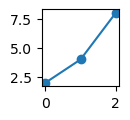

cpu


In [ ]:
import math
import time
import numpy as np

import os  
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
fig=plt.figure(figsize=(1,1))
plt.plot([0,1,2], [2,4,8], '-o')
plt.show()

# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# set device and rand num generators
device = torch.device('cpu')
torch.manual_seed(42)
np.random.seed(42)
print(device)

## Define the Linear SDE: drift and diffusion

For K=2 every matrix of the form  [[-a, b], [-b, -a]], with b!= 0 gives rise to
a SDE that violates detailed balance, therefore the trajectories of relaxation
and those of large fluctuations are not one the time reversal of the other.

In [15]:
def make_A(K=2, a=1.0, b=2.0, device='cpu'):
    
    """Constructs a linear drift matrix A such that f(x) = A x.
    For K=2: [[-a, b], [-b, -a]]  (spiral in the plane)
    For K=3: [[-a, b, 0], [-b, -a, 0], [0, 0, -a]]  (spiral in x-y, contraction in z)

    """
    A = torch.zeros(K, K, device=device)
    
    if K==2:
        A[0,0] = -a
        A[0,1] = b
        A[1,0] = -b
        A[1,1] = -a
    if K==3:
        A[0,:] = torch.Tensor([-a,b,0])
        A[1,:] = torch.Tensor([-b,-a,0])
        A[2,:] = torch.Tensor([0,0,-a])
        
    return A

In [16]:
make_A(K=3, a=1.0, b=2.0, device='cpu')

tensor([[-1.,  2.,  0.],
        [-2., -1.,  0.],
        [ 0.,  0., -1.]])

In [17]:
def f_drift(x, A):
    return x @ A.T  # batch x K

def expm_tA(A, t):
    """Compute expm(A * t) via torch.matrix_exp."""
    return torch.matrix_exp(A * t)

def conditional_mean(A, x0, t):
    E = expm_tA(A, t)  # K x K
    return (E @ x0.T).T  # batch x K

def conditional_cov_old(A, sigma, t):

    """Compute P(t) = ∫_0^t exp(A s) (sigma^2 I) exp(A^T s) ds via Van Loan method.
    Uses matrix exponential of block matrix [[A, Q],[0, A^T]] where Q = sigma^2 I.
    Returns K x K covariance.
    """
    
    K = A.shape[0]
    Q = (sigma**2) * torch.eye(K, device=A.device)
    top = torch.cat([A, Q], dim=1)
    bottom = torch.cat([torch.zeros_like(A), A.T], dim=1)
    M = torch.cat([top, bottom], dim=0)  # (2K) x (2K)
    expM = torch.matrix_exp(M * t)
    # The top-right block is ∫_0^t e^{A s} Q e^{A^T s} ds
    S = expM[:K, K:]
    return S

def conditional_cov(A, sigma, t, a=1):
    
    K = A.shape[0]
    I = torch.eye(K, device=A.device)
    P_inf = (sigma**2) / (2.0 * a) * I
    E = torch.matrix_exp(A * t)
    P = P_inf - E @ P_inf @ E.T
    # Symmetrize and clip tiny negatives from numerical noise
    P = 0.5 * (P + P.T)
    eigvals, eigvecs = torch.linalg.eigh(P)
    eigvals = torch.clamp(eigvals, min=0.0)
    P = (eigvecs * eigvals) @ eigvecs.T
    return P

def conditional_sample(A, sigma, x0, t):
    """Sample x(t) ~ N(m(t), P(t)). Returns sample and (m, P)."""
    m = conditional_mean(A, x0, t)  # batch x K
    P = conditional_cov(A, sigma, t)  # K x K
    # Cholesky (with jitter for stability)
    jitter = 1e-6
    Pj = P + jitter * torch.eye(P.shape[0], device=P.device)
    L = torch.linalg.cholesky(Pj)
    z = torch.randn_like(m)  # batch x K
    x = m + z @ L.T
    return x, m, P

## Score Network $s_\theta(x,t)$ (simple MLP with time conditioning)

In [7]:
class TimeEmbedding(nn.Module):
    '''
    Convert times into high-dim vectors
    '''
    def __init__(self, embed_dim=32, max_period=10000.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_period = max_period
        # Use half sin, half cos
        self.freqs = None  # created on the fly
    
    def forward(self, t):
        # t: (batch,)
        if self.freqs is None:
            # Create frequencies
            half = self.embed_dim // 2
            device = t.device
            freqs = torch.exp(
                -math.log(self.max_period) * torch.arange(0, half, device=device).float() / max(half - 1, 1)
            )
            self.freqs = freqs
        # shape (batch, half)
        angles = t[:, None] * self.freqs[None, :]
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        if emb.shape[1] < self.embed_dim:
            # pad if odd embed_dim
            emb = F.pad(emb, (0, self.embed_dim - emb.shape[1]), value=0.0)
        return emb

In [18]:
class ScoreNet(nn.Module):
    '''
    A simple mlp that takes as input (t_embedded, x1, x2,...xK) and outputs
    the components of the vector score (s1,s2,...,sK)
    '''
    def __init__(self, K=2, hidden=128, time_embed_dim=32):
        super().__init__()
        self.time_embed = TimeEmbedding(embed_dim=time_embed_dim)
        inp = K + time_embed_dim
        self.net = nn.Sequential(
            nn.Linear(inp, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, K),
        )
    
    def forward(self, x, t):
        # x: (batch, K), t: (batch,) in [0,T]
        temb = self.time_embed(t)
        h = torch.cat([x, temb], dim=-1)
        return self.net(h)

## Training by Denoising Score Matching on the conditional Gaussian $p_{0t}(x_t\mid x_0)$

In [21]:
#torch.rand?

In [19]:
def train_score_model(K=2, 
                      a=1.0, 
                      b=2.0, 
                      sigma=1.0, 
                      T=5.0,
                      init_dist='quarter_circle', 
                      R=10.0, # for K=2
                      R_ball=5.0, # for general K ball
                      iters=1500, 
                      batch_size=512, 
                      lr=1e-3, 
                      print_every=200, 
                      device='cpu'):
    
    A = make_A(K=K, a=a, b=b, device=device)
    model = ScoreNet(K=K).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    model.train()
    for it in range(1, iters+1):
        
        # Sample initial x0
        if K == 2 and init_dist == 'quarter_circle':
            x0 = sample_quarter_circle_2d(batch_size, R=R, device=device)
        else:
            x0 = sample_uniform_ball(batch_size, K=K, R=R_ball, device=device)

        # Sample random times uniformly in [0,T)
        t = torch.rand(batch_size, device=device) * T
        
        # For each sample, draw x(t) ~ N(m(t), P(t))
        # We'll do this in a loop for clarity (K is tiny), vectorization is also possible.
        xs = []
        ms = []
        P_invs = []
        for i in range(batch_size):
            xi0 = x0[i:i+1, :]  # 1 x K
            ti = t[i]
            x_t, m_t, P_t = conditional_sample(A, sigma, xi0, ti)
            xs.append(x_t)
            ms.append(m_t)
            # Inverse covariance
            Pj = P_t + 1e-6 * torch.eye(K, device=device)
            P_inv = torch.linalg.inv(Pj)
            P_invs.append(P_inv)
        x = torch.cat(xs, dim=0)     # batch x K
        m = torch.cat(ms, dim=0)     # batch x K
        P_inv = torch.stack(P_invs)  # batch x K x K
        
        # Target conditional score: ∇_x log N(x; m, P) = - P^{-1} (x - m)
        target = torch.einsum('bij,bj->bi', -P_inv, (x - m))
        
        # Predict score
        pred = model(x, t)
        loss = F.mse_loss(pred, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
        if it % print_every == 0 or it == 1:
            print(f"[{it}/{iters}] loss = {loss.item():.5f}")
    
    return model, A, torch.tensor(sigma, device=device), torch.tensor(T, device=device), losses

## Reverse-Time Sampling: Euler–Maruyama (SDE) and Probability Flow ODE

In [10]:
@torch.no_grad()
def sample_reverse_sde(model, A, sigma, T, N=1000, steps=500, init_from_forward=True, 
                       K=2, init_dist='quarter_circle', R=10.0, R_ball=5.0, device='cpu'):
    model.eval()
    dt = T.item() / steps
    # Initialize x_T
    if init_from_forward:
        # Approx p_T by simulating forward for a batch of samples, then take their empirical distribution
        if K == 2 and init_dist == 'quarter_circle':
            x0 = sample_quarter_circle_2d(N, R=R, device=device)
        else:
            x0 = sample_uniform_ball(N, K=K, R=R_ball, device=device)
        # Simulate forward with Euler-Maruyama to T
        xT = x0.clone()
        nsteps = steps
        h = T.item() / nsteps
        sqrt_h = math.sqrt(h)
        for _ in range(nsteps):
            drift = f_drift(xT, A)
            noise = torch.randn_like(xT) * sigma.item() * sqrt_h
            xT = xT + drift * h + noise
        x = xT
    else:
        # Start from stationary Gaussian approx (solve Lyapunov for P_inf: A P + P A^T + sigma^2 I = 0)
        # Here we just start at 0 for simplicity.
        x = torch.randn(N, K, device=device) * (sigma.item() * 0.1)
    
    # Reverse SDE integration (from T to 0) with negative dt
    for s in range(steps):
        t = T - s * dt  # current time
        t_batch = torch.full((N,), t.item(), device=device)
        score = model(x, t_batch)
        drift = f_drift(x, A) - (sigma**2) * score
        # Euler-Maruyama step backward
        x = x - drift * dt + sigma * math.sqrt(dt) * torch.randn_like(x)
    return x

@torch.no_grad()
def sample_reverse_ode(model, A, sigma, T, N=1000, steps=500, init_from_forward=True, 
                       K=2, init_dist='quarter_circle', R=10.0, R_ball=5.0, device='cpu'):
    model.eval()
    dt = T.item() / steps
    # Initialize x_T
    if init_from_forward:
        if K == 2 and init_dist == 'quarter_circle':
            x0 = sample_quarter_circle_2d(N, R=R, device=device)
        else:
            x0 = sample_uniform_ball(N, K=K, R=R_ball, device=device)
        # Simulate forward to T (Euler)
        xT = x0.clone()
        nsteps = steps
        h = T.item() / nsteps
        for _ in range(nsteps):
            drift = f_drift(xT, A)
            xT = xT + drift * h  # deterministic forward (no noise) to get near origin
        x = xT
    else:
        x = torch.randn(N, K, device=device) * (sigma.item() * 0.1)
    
    # Probability flow ODE backward integration
    for s in range(steps):
        t = T - s * dt
        t_batch = torch.full((N,), t.item(), device=device)
        score = model(x, t_batch)
        drift = f_drift(x, A) - 0.5 * (sigma**2) * score
        x = x - drift * dt
    return x

## Visualization Helpers

In [37]:
def plot_forward_trajectories_2d(A, sigma, T=5.0, n_traj=5, R=10.0, steps=50, alpha=0.3):
    plt.figure(figsize=(5,5))
    x0 = sample_quarter_circle_2d(n_traj, R=R, device=device)
    colors = ['-', '--', '-.', ':', '-']
    h = T / steps
    sqrt_h = math.sqrt(h)
    for i in range(n_traj):
        xi = x0[i:i+1, :].clone()
        xs = [xi[0,0].item()]; ys = [xi[0,1].item()]
        for _ in range(steps):
            drift = f_drift(xi, A)
            noise = torch.randn_like(xi) * sigma * sqrt_h
            xi = xi + drift * h + noise
            xs.append(xi[0,0].item()); ys.append(xi[0,1].item())
        plt.plot(xs, ys, 'k', alpha=alpha)  # do not set colors explicitly per instructions
    # origin
    plt.scatter([0.0], [0.0], s=40)
    # initial points
    plt.scatter(x0[:,0].cpu().numpy(), x0[:,1].cpu().numpy(), s=30, color = 'k', alpha=alpha)
    plt.title("Forward SDE trajectories (2D)")
    plt.xlabel("x"); plt.ylabel("y")
    plt.axis('equal'); plt.grid(True)
    plt.show()

def plot_distribution_slices_2d(samples_list, titles, bins=80, lim=12.0):
    # Plot 2D hist for multiple time slices (separate figures as required)
    for samples, title in zip(samples_list, titles):
        plt.figure(figsize=(5,5))
        x = samples[:,0].cpu().numpy()
        y = samples[:,1].cpu().numpy()
        plt.hist2d(x, y, bins=bins, range=[[-lim, lim], [-lim, lim]])
        plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.axis('equal'); plt.grid(True)
        plt.show()

def plot_scatter_3d(points, title=""):
    pts = points.cpu().numpy()
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=5, alpha=0.5)
    ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    lim = float(1.2 * np.max(np.abs(pts)))
    for axis in [ax.set_xlim, ax.set_ylim, ax.set_zlim]:
        axis([-lim, lim])
    plt.show()


## 2D Demo: Quarter-Circle $p_0$, Spiral Drift, Small Isotropic Diffusion

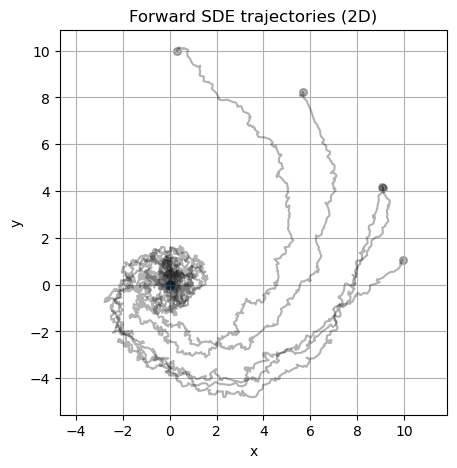

In [41]:
# Parameters
K = 2
a, b = 1.0, 2
sigma_val = 1
T_val = 5.0
R_quarter = 10.0
steps = 1000

# Visualize a few forward trajectories to build intuition
A_2d = make_A(K=2, a=a, b=b, device=device)

sigma_t = torch.tensor(sigma_val, device=device)

plot_forward_trajectories_2d(A_2d, sigma_t, T=T_val, n_traj=5, R=R_quarter, steps=steps)

In [115]:
# Train score model on conditional DSM objective
model_2d, A_2d, sigma_t, T_t, losses_2d = train_score_model(
    K=2, a=a, b=b, sigma=sigma_val, T=T_val,
    init_dist='quarter_circle', R=R_quarter,
    iters=800, batch_size=256, lr=1e-3, device=device, print_every=200
)

[1/800] loss = 4.27746
[200/800] loss = 2.10388
[400/800] loss = 0.78924
[600/800] loss = 1.24865
[800/800] loss = 0.89050


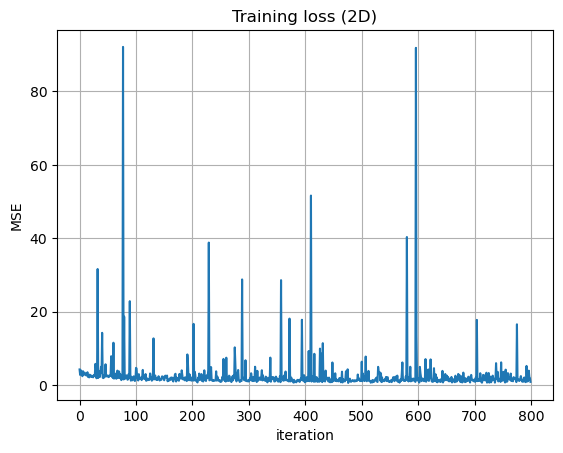

In [116]:
plt.figure()
plt.plot(losses_2d)
plt.title("Training loss (2D)"); plt.xlabel("iteration"); plt.ylabel("MSE"); plt.grid(True); plt.show()

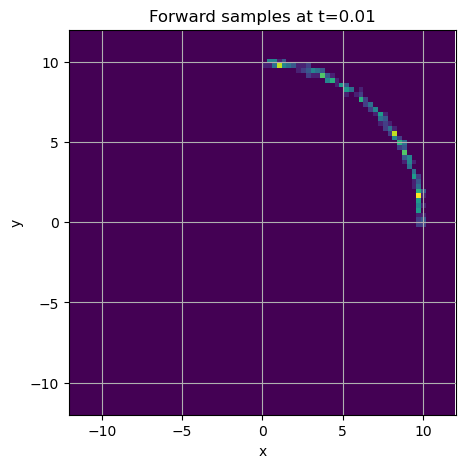

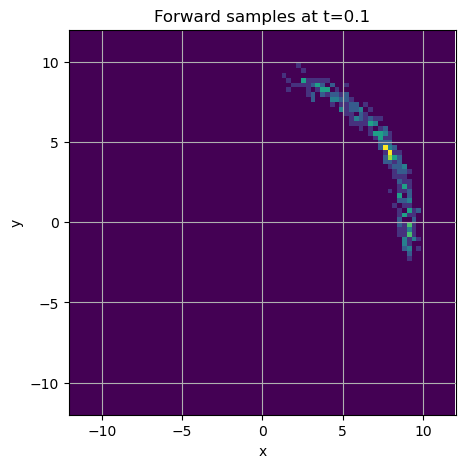

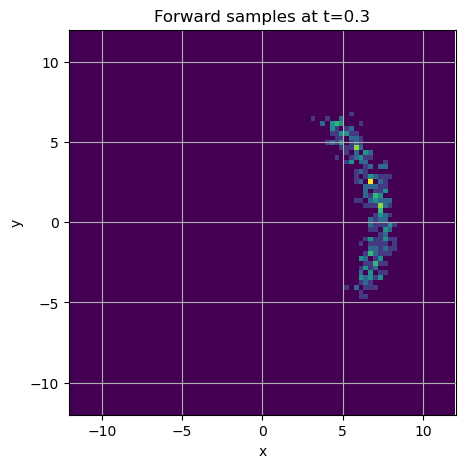

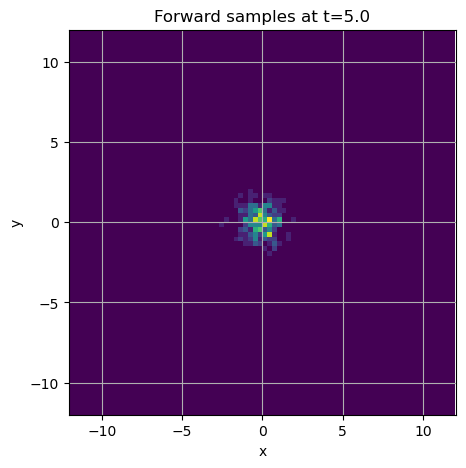

In [120]:
# Visualize p_T and a few intermediate time distributions (by sampling conditional x(t)|x0)
times = [0.01, 0.1, 0.3, 5.0]
samples_list = []
for t in times:
    x0 = sample_quarter_circle_2d(300, R=R_quarter, device=device)
    xs = []
    for i in range(x0.shape[0]):
        xi, _, _ = conditional_sample(A_2d, sigma_t, x0[i:i+1,:], torch.tensor(t, device=device))
        xs.append(xi)
    xs = torch.cat(xs, dim=0)
    samples_list.append(xs)
plot_distribution_slices_2d(samples_list, [f"Forward samples at t={t}" for t in times], lim=R_quarter+2.0)

In [ ]:
# Reverse-time sampling: SDE and ODE
x_sde_2d = sample_reverse_sde(model_2d, A_2d, sigma_t, T_t, N=2000, steps=600,
                              init_from_forward=True, K=2, init_dist='quarter_circle', R=R_quarter, device=device)

In [ ]:
x_ode_2d = sample_reverse_ode(model_2d, A_2d, sigma_t, T_t, N=2000, steps=600,
                              init_from_forward=True, K=2, init_dist='quarter_circle', R=R_quarter, device=device)

In [ ]:
# Compare to the original data manifold (quarter circle)
theta = torch.linspace(0, 0.5*math.pi, 500, device=device)
arc = torch.stack([R_quarter*torch.cos(theta), R_quarter*torch.sin(theta)], dim=-1)

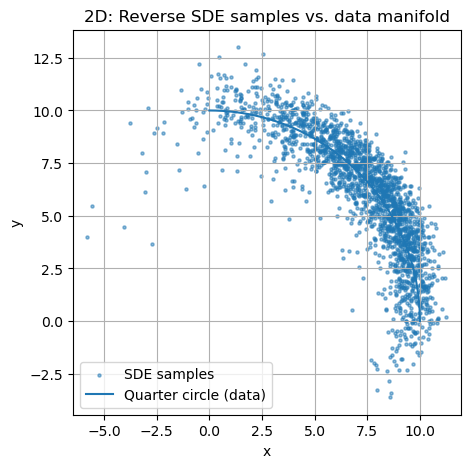

In [122]:
plt.figure(figsize=(5,5))
plt.scatter(x_sde_2d[:,0].cpu().numpy(), x_sde_2d[:,1].cpu().numpy(), s=5, alpha=0.5, label='SDE samples')
plt.plot(arc[:,0].cpu().numpy(), arc[:,1].cpu().numpy(), label='Quarter circle (data)')
plt.title("2D: Reverse SDE samples vs. data manifold")
plt.xlabel("x"); plt.ylabel("y"); plt.axis('equal'); plt.grid(True); plt.legend(); plt.show()

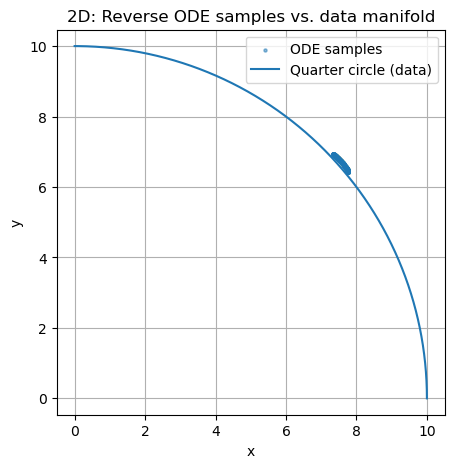

In [126]:
plt.figure(figsize=(5,5))
plt.scatter(x_ode_2d[:,0].cpu().numpy(), x_ode_2d[:,1].cpu().numpy(), s=5, alpha=0.5, label='ODE samples')
plt.plot(arc[:,0].cpu().numpy(), arc[:,1].cpu().numpy(), label='Quarter circle (data)')
plt.title("2D: Reverse ODE samples vs. data manifold")
plt.xlabel("x"); plt.ylabel("y"); plt.axis('equal'); plt.grid(True); plt.legend(); plt.show()

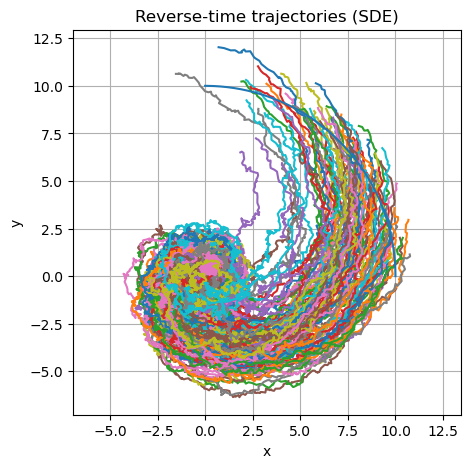

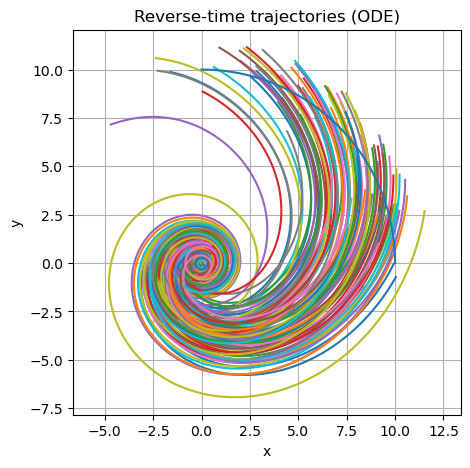

In [127]:
from plot_reverse_trajectories_2d_v2 import plot_reverse_trajectories_2d

# After training your 2D model and defining A_2d, sigma_t, T_t:
plot_reverse_trajectories_2d(
    model=model_2d,
    A=A_2d,          # 2x2 tensor
    sigma=sigma_t,   # scalar (tensor or float)
    T=T_t,           # scalar (tensor or float)
    n_traj=100,
    steps=800,
    R=10.0,
    init_from_forward=True,   # initialize x_T by simulating forward from quarter circle
    device=device
)


## 3D Demo: Uniform-in-Ball $p_0$, Spiral-in-XY + Converging-Z Drift

In [35]:

# Parameters
K = 3
a, b = 1.0, 2.0
sigma_val = 1.0
T_val = 5.0
R_ball = 5.0

# Train score model on 3D data from the forward SDE
model_3d, A_3d, sigma_t3, T_t3, losses_3d = train_score_model(
    K=3, a=a, b=b, sigma=sigma_val, T=T_val,
    init_dist='ball', R_ball=R_ball,
    iters=800, batch_size=256, lr=1e-3, device=device, print_every=200
)

plt.figure()
plt.plot(losses_3d)
plt.title("Training loss (3D)"); plt.xlabel("iteration"); plt.ylabel("MSE"); plt.grid(True); plt.show()

# Visualize forward samples at a few times
times = [0.5, 1.5, 3.0, 5.0]
for t in times:
    x0 = sample_uniform_ball(4000, K=3, R=R_ball, device=device)
    xs = []
    for i in range(x0.shape[0]):
        xi, _, _ = conditional_sample(A_3d, sigma_t3, x0[i:i+1,:], torch.tensor(t, device=device))
        xs.append(xi)
    xs = torch.cat(xs, dim=0)
    plot_scatter_3d(xs, title=f"Forward samples at t={t}")

# Reverse-time ODE sampling (deterministic) and comparison
x_ode_3d = sample_reverse_ode(model_3d, A_3d, sigma_t3, T_t3, N=3000, steps=600,
                              init_from_forward=True, K=3, init_dist='ball', R_ball=R_ball, device=device)
x0_true = sample_uniform_ball(3000, K=3, R=R_ball, device=device)

plot_scatter_3d(x0_true, title="Original p0 (uniform ball, 3D)")
plot_scatter_3d(x_ode_3d, title="Generated samples (reverse ODE, 3D)")


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).


## How to plug this into `yang-song/score_sde`

To integrate this setup into the original repository:

1. **Add a custom SDE** (linear, non-reversible drift, isotropic diffusion) to `sde_lib.py`:
   ```python
   class CentralSpiralSDE(SDE):
       def __init__(self, a=1.0, b=2.0, sigma=1.0):
           super().__init__(N=1000, T=5.0)  # choose N, T as needed
           self.a, self.b, self.sigma = a, b, sigma

       def sde(self, x, t):
           # x: (batch, K)
           K = x.shape[-1]
           A = make_A_torch(K, self.a, self.b, x.device)  # same block form as in this notebook
           drift = x @ A.transpose(-1, -2)
           diffusion = torch.ones_like(x) * self.sigma
           return drift, diffusion

       def marginal_prob(self, x0, t):
           # Return mean and std (or covariance) for x(t)|x0
           # Use matrix exponential and Van Loan as shown in this notebook.
           raise NotImplementedError  # implement with torch.matrix_exp

       def prior_sampling(self, shape):
           # Sample from approximate p_T; e.g., N(0, I) scaled suitably
           return torch.randn(shape, device=x.device) * (self.sigma * 0.1)
   ```
   You can copy the `make_A` and Van Loan covariance code from earlier cells.

2. **Dataset / Samplers**: create a low-dim dataset class that draws `x0` from your chosen `p0` (quarter circle or ball). For the quarter circle, sample angles in `[0, π/2]` and set `x0 = (R cos θ, R sin θ)`. For the ball, use the `sample_uniform_ball` function.

3. **Training**: use the repository's continuous training loop but feed your `marginal_prob` to compute the denoising score matching targets (conditional Gaussian). Alternatively, switch to sliced score matching if you prefer simulating the forward SDE without closed-form conditionals.

4. **Sampling**: use the repository's Euler–Maruyama sampler (predictor-only) for reverse SDE and the probability flow ODE sampler to match this notebook's behavior.
